# Setup

In [1]:
import requests
import json
import datetime
import time
import pandas as pd
from selenium import webdriver 
from selenium.webdriver import ActionChains
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from matplotlib import pyplot as plt

In [2]:
# Chart SharePrice/NetAssetValue
# X = Time
# Y = Percetage from one

# Scrape Data from macrotrends.com

In [3]:
chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome()

# url = 'https://www.macrotrends.net/stocks/charts/AMZN/amazon/income-statement?freq=Q'
url = 'https://www.macrotrends.net/stocks/charts/AMZN/amazon/balance-sheet?freq=Q'
driver.get(url)
geturl = driver.current_url

In [4]:
#find scroll and slide to right
scroller =  driver.find_element(By.XPATH, '//div[@id="jqxScrollThumbhorizontalScrollBarjqxgrid"]')
end_scroller = driver.find_element(By.XPATH, '//div[@id="jqxScrollBtnDownhorizontalScrollBarjqxgrid"]')
move = ActionChains(driver)
# move.click_and_hold(scroller).move_by_offset(120, 0).release().perform()
# move.click_and_hold(scroller).move_to_element(end_scroller).perform()
headers_el = driver.find_element(By.XPATH, '//div[@id="columntablejqxgrid"]')
table_el = driver.find_element(By.XPATH, '//div[@id="contenttablejqxgrid"]')
rows_el = table_el.find_elements(By.XPATH, '//div[@role="row"]')


In [5]:

def getAttribute():
    '''
    Get attribute for infinity scroll loader
    Return z-index position
    '''
    
    headers = headers_el.find_elements(By.XPATH, '//div[@role="columnheader"]')
    l = []
    for header in headers:
        styles = header.get_dom_attribute('style').split('; ')
        l2 = []
        # print(styles)
        for style in styles:
            # print(style)
            l2.append(map(str.strip, style.split(': ', 1)))
        l.append(dict(l2))

    out = [int(i['z-index']) for i in l]
    out.sort(reverse=True)
    return out[2:len(out)]

# Fetch data

In [6]:
def fetchToDf():
    '''
    Parse html to pd.DataFrame
    '''
    headertext = headers_el.text.split('\n')
    datatext = [row.text.split('\n')[:len(headertext)] for row in rows_el]
    df = pd.DataFrame(data=datatext, columns=headertext)
    return df.set_index(df.columns[0])

def merge2Df(prev_df, next_df):
    '''
    Merge 2 Df frome infinity scrool load
    '''
    df = prev_df.combine_first(next_df)
    return df

In [8]:
# 1. Get current_pos
# 2. Constantly scrolling
# 3. Get update_pos
# 4. When update_pos <= current_pos-5
# 4.1 Stop scrolling
# 4.2 Fetch data
# 4.3 Update current_pos to current position-5
# 5. When scroll not update anymore position
# 5.1 Break loop

# Scroll load maximum 6 cols, use -5 to ruduce over scrolling error
current_pos = min(getAttribute())-5
# print(f'current_pos: {current_pos} of {getAttribute()}')
last_pos = 0
repetness = 0
out_df = pd.DataFrame()
# For debugging
# i = []

while True:
    # constanly slide and update
    move.click_and_hold(end_scroller).perform()
    time.sleep(1)
    update_pos = min(getAttribute())
    # print(f'update_pos: {update_pos} of {getAttribute()}')
    
    # if last list is loaded do fetch data
    if update_pos <= current_pos:
        
        # print('cur == upd')
        move.release(end_scroller)
        # fetch_df = fetchToDf()
        # i.append(fetch_df)
        
        #do something
        if out_df.empty:
            out_df = fetchToDf()
        elif not out_df.empty:
            out_df = merge2Df(out_df, fetchToDf())
        
        current_pos = min(getAttribute())-5
        # print(f'current_pos: {current_pos} of {getAttribute()}')
        
    # if no more update
    if last_pos == update_pos:
        
        # print(last_pos)
        repetness += 1
        # print(repetness)

        # more than 10 time, break
        if repetness == 4:
            # i.append(fetchToDf())
            break
        
    elif last_pos != update_pos:
        repetness = 0
    
    last_pos = update_pos

In [9]:
out_df.head(5)

""


In [10]:
# out_df.to_csv('/Users/lumlong/Desktop/d_AMZN.csv')

# Parse data

In [11]:
df = pd.read_csv('/Users/lumlong/Desktop/d_AMZN.csv')

In [12]:
df = df.set_index(df.columns[0]).T
df.columns.name = 'Date'
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

# parsed_df = df[df.columns[0:]].replace('[\$,]', '', regex=True)
df = df.replace('[\$,]', '', regex=True)
df = df.replace('-', 0)
df = df.astype('float', errors='ignore')

In [ ]:
df.head(5)

In [13]:
asset_selected_df = df[df.index > datetime.datetime(2016, 3, 31)]

In [14]:
# df['Total Assets'].apply(lambda x: (x/x.iloc[0])-1)
# df['Total Assets pct'] = 100 * (1 - df['Total Assets'].iloc[0] / df['Total Assets'])

asset_selected_df['pct_change'] = (asset_selected_df['Total Assets'] / asset_selected_df['Total Assets'].iloc[0] - 1) * 100

/var/folders/hy/qt5ys1v514bd88slhsnqqf_w0000gn/T/ipykernel_3603/2277241534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asset_selected_df['pct_change'] = (asset_selected_df['Total Assets'] / asset_selected_df['Total Assets'].iloc[0] - 1) * 100


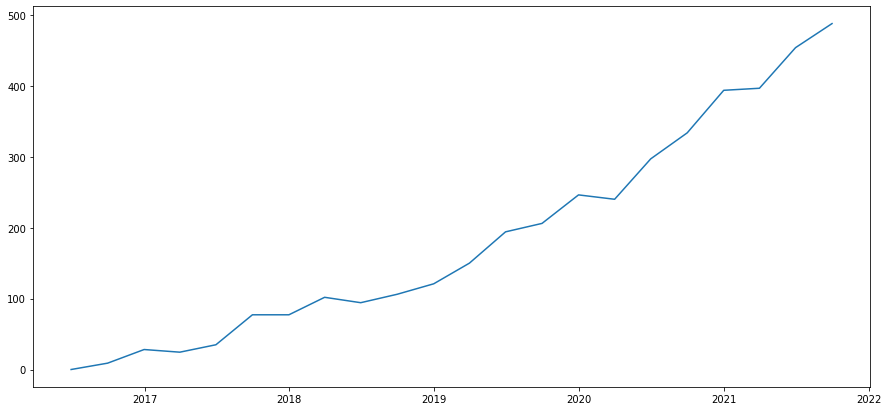

In [15]:
plt.figure(figsize = (15,7))
plt.plot(asset_selected_df.index, asset_selected_df['pct_change'])

# Price data from csv

In [16]:
price_df = pd.read_csv('/Users/lumlong/Desktop/MacroTrends_Data_Download_AMZN.csv', on_bad_lines='skip')

In [17]:
price_df = price_df.set_index('date')
price_df.index = pd.to_datetime(price_df.index, format='%Y-%m-%d')
price_selected_df = price_df[price_df.index > datetime.datetime(2016,3,31)]

In [18]:
price_selected_df['pct_change'] = (price_selected_df['close'] / price_selected_df['close'].iloc[0] - 1) * 100

/var/folders/hy/qt5ys1v514bd88slhsnqqf_w0000gn/T/ipykernel_3603/3755959216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_selected_df['pct_change'] = (price_selected_df['close'] / price_selected_df['close'].iloc[0] - 1) * 100


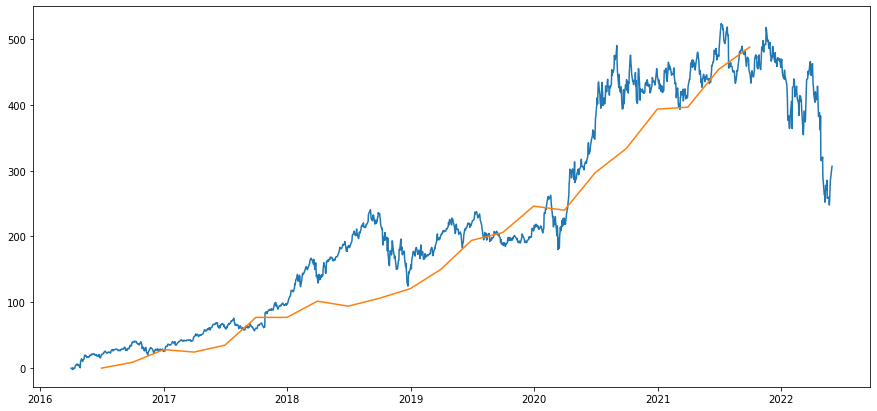

In [19]:
plt.figure(figsize = (15,7))
plt.plot(price_selected_df.index, price_selected_df['pct_change'])
plt.plot(asset_selected_df.index, asset_selected_df['pct_change'])